In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pyhessian
import Optimizers
import random
from LeNet import *
from Helpers import *
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [16]:
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### Data load

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
batch_size = 100
learning_rate = 0.1

In [20]:
import torchvision
import torchvision.datasets as datasets
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [21]:
if not os.path.isdir('./data/mnist'):
    mnist_trainset = datasets.MNIST(root = './data/mnist/train', train = True, download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
    mnist_testset = datasets.MNIST(root = './data/mnist/test', train = False, download = True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
else:
    mnist_trainset = datasets.MNIST(root = './data/mnist/train', train = True, download = False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))
    mnist_testset = datasets.MNIST(root = './data/mnist/test', train = False, download = False, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/test/MNIST/raw



In [22]:
type(mnist_trainset)

torchvision.datasets.mnist.MNIST

In [23]:
train_data_tmp = [mnist_trainset[i][0] for i in range(len(mnist_trainset))]
tmp = torch.Tensor(len(mnist_trainset),1, 32, 32)
train_data = torch.cat(train_data_tmp, out=tmp)
train_data = train_data.reshape(len(train_data),1,32,32).to(device)

train_target = torch.Tensor([[mnist_trainset[i][1] for i in range(len(mnist_trainset))]]).reshape(-1)
train_target = train_target.long().to(device)

In [24]:
test_data_tmp = [mnist_testset[i][0] for i in range(len(mnist_testset))]
tmp = torch.Tensor(len(mnist_testset),1, 32, 32)
test_data = torch.cat(test_data_tmp, out=tmp)
test_data = test_data.reshape(len(test_data),1,32,32).to(device)

test_target = torch.Tensor([[mnist_testset[i][1] for i in range(len(mnist_testset))]]).reshape(-1)
test_target = test_target.long().to(device)

#### Model training

In [25]:
epochs = 150

In [27]:
def train(model, train_data, train_target, name, lr = 0.1):
    if name != 'adam' and name != 'adagrad' :
        optimizer = Optimizers.get_optimizer(model, name, lr)
    if name=='adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.004722222222222222 ,betas=(0.675 ,0.999))
    if name=='adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr = 0.0012)
    loss = nn.CrossEntropyLoss()
    grad_norm = []
    for i in range(epochs):
        for b in range(0,train_data.size(0), batch_size):
            optimizer.zero_grad()
            train_batch_data = train_data[b : b + batch_size]
            train_batch_target = train_target[b : b + batch_size]
            y_hat = model(train_batch_data)
            l = loss(y_hat, train_batch_target)
            if name.lower() == 'adahessian':
                l.backward(create_graph = True)
            else:
                l.backward()
            optimizer.step()
        grad_norm.append(norm_gradient(model))
    return model, grad_norm

In [28]:
def test(model, test_data, test_target):
    nb_errors  = 0
    i = 0
    for b in range(0,test_data.size(0), batch_size):
    with torch.no_grad():
        y_hat = model(test_data[b:b+batch_size])
        _, pr = y_hat.max(1)
        for k in range(batch_size):
            if pr[k] != test_target[k + b]:
                nb_errors += 1
    return (test_data.size(0)-nb_errors)/test_data.size(0)

In [29]:
first_order = ['adam', 'sgd', 'adagrad']
#first_order = ['adam']
second_order = ['adahessian']
first_order_perf = {}
second_order_perf = {}

In [30]:
for first_order_method in first_order:
    print(first_order_method)
    model = LeNet(batch_size).to(device)
    model, grad_norms = train(model, train_data, train_target,first_order_method) 
    error = test(model, test_data, test_target)
    first_order_perf[first_order_method] = (error,model,grad_norms)
    print(error)
    print("------------------------------------------------------------")

adam
ok
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
0.9813
------------------------------------------------------------
sgd
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
0.9902
------------------------------------------------------------
adagrad
ok
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
0.9822
------------------------------------------------------------


Plot gradient norm with repect to the epoch for every first order optimizers

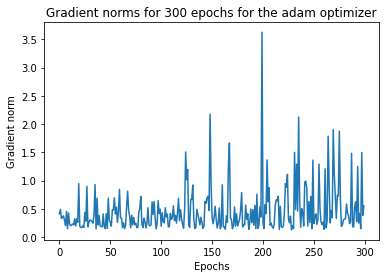

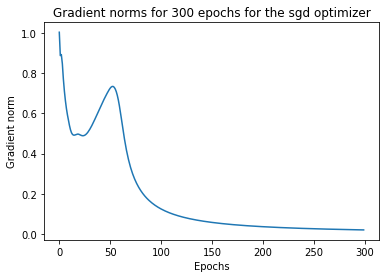

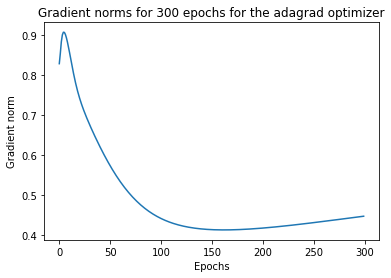

In [31]:
for k, value in first_order_perf.items():
    opt_name = k
    grad_norms = value[-1]
    plot_grad_norms_per_optimizer(opt_name, grad_norms, epochs)

training with adahessian

In [32]:
for second_order_method in second_order:
    print(second_order_method)
    model =LeNet(batch_size).to(device)
    model, grad_norms = train(model, train_data, train_target,second_order_method)
    error = test(model, test_data, test_target)
    second_order_perf[second_order_method] = error,model,grad_norms
    print(error)  
    print("------------------------------------------------------------")

adahessian


/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:175: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:985.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
0.9888
------------------------------------------------------------


plotting gradient norm for the model trained with adahessian

In [ ]:
for k, value in second_order_perf.items():
    opt_name = k
    grad_norms = value[-1]
    plot_grad_norms_per_optimizer(opt_name, grad_norms, epochs)

In [ ]:
optimizers_to_top_5_eigenvalues = {}
optimizers_to_hessian_trace = {}
i = 0
model_batch_size = 60_000
inputs, targets = train_data[model_batch_size*i:model_batch_size*(i+1)],train_target[model_batch_size*i:model_batch_size*(i+1)]

In [ ]:
model = first_order_perf["sgd"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with SGD")

In [ ]:
model = first_order_perf["adagrad"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with AdaGrad")

In [ ]:
model = first_order_perf["adam"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with Adam")

In [ ]:
model = second_order_perf["adahessian"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
density_eigen, density_weight = hessian_comp.density()
get_esd_plot(density_eigen, density_weight,"Eigenvalue density plot for the model trained with AdaHessian")

In [ ]:
#a nice function to perturbate the parameters of the model alongside 1 direction
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

In [ ]:
#a nice function to perturbate the parameters of the model alongside 2 direction
def get_params2(model_orig,  model_perb, direction,direction2, alpha,beta):
    for m_orig, m_perb, d ,d2 in zip(model_orig.parameters(), model_perb.parameters(), direction,direction2):
        m_perb.data = m_orig.data + alpha * d+ beta * d2
    return model_perb

Plotting the loss landscape

In [ ]:
model = first_order_perf["sgd"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with sgd')  

In [ ]:
model = first_order_perf["adagrad"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with adagrad')    

In [ ]:
model = first_order_perf["adam"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with adam')    

In [ ]:
model = second_order_perf["adahessian"][1]
criterion = nn.CrossEntropyLoss()
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)


lams =  np.linspace(-1, 1, 40).astype(np.float32)

loss_list = []
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector for the model trained with adahessian')  

In [ ]:
def get_params2(model_orig,  model_perb, direction,direction2, alpha,beta):
    for m_orig, m_perb, d ,d2 in zip(model_orig.parameters(), model_perb.parameters(), direction,direction2):
        m_perb.data = m_orig.data + alpha * d+ beta * d2
    return model_perb

Plotting the 3d land

In [ ]:
from pyhessian.utils import normalization
model = first_order_perf["adam"][1]
criterion = nn.CrossEntropyLoss()

model = first_order_perf["adam"][1]
hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
precision=30
lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()

model.zero_grad()
loss = criterion(model(inputs), targets)
loss.backward()

v = [p.grad.data for p in model.parameters()]
v = normalization(v)
model.zero_grad()

def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],v, lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
    for j in range(precision):
        Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


In [ ]:
model = first_order_perf["adagrad"][1]
criterion = nn.CrossEntropyLoss()
precision=40

hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()
def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],top_eigenvector[1], lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
    for j in range(precision):
        Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
ax.set_xlabel('top_eigenvector')
ax.set_ylabel('second_eigenvector')
ax.set_zlabel('loss');

In [ ]:
ax.view_init(40, 70)
fig

In [ ]:
model = first_order_perf["sgd"][1]
criterion = nn.CrossEntropyLoss()
precision=40

hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()
def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],top_eigenvector[1], lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
    for j in range(precision):
        Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
ax.view_init(60, 35)
fig

In [ ]:
model = second_order_perf["adahessian"][1]
criterion = nn.CrossEntropyLoss()
precision=30

hessian_comp = pyhessian.hessian(model, criterion, data=(inputs, targets), cuda=True)
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)

lams =  torch.linspace(-2, 2, precision)
mus =  torch.linspace(-2, 2 , precision)
X, Y = torch.meshgrid(lams, mus, indexing='xy')
loss_list = []

model_perb = LeNet(model_batch_size)
model_perb.eval()
model_perb = model_perb.cuda()
def f(model,modelp,lam,mu):
    model_perb = get_params2(model, modelp, top_eigenvector[0],top_eigenvector[1], lam,mu)
    
    return criterion(model_perb(inputs), targets).item()

Z=torch.ones_like(X)
for i in range(precision):
    for j in range(precision):
        Z[i][j]=f(model,model_perb,X[i][j],Y[i][j])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), Z.numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [ ]:
ax.view_init(60, 35)
fig